In [28]:
import pandas as pd
import numpy as np
from statistics import mode
from scipy.spatial.distance import euclidean
from dtw import dtw
import os
import cv2  

from collections import Counter
import re
import datetime
import random

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

import tensorflow as tf

### Objectives
* Choose two players who reach same scores(stop forcely)
* Choose two players who play the same time(stop forcely)
* Calculate their statistical result(variance, average, mode, etc.)
* Visualization in terms of HR, Emotional, Collection of Emoji
* According to the movement of birds(HR of players) to find out their similarity using Dynamic Time Warping algorithm

In [3]:
# all the function we need to parse the data
def extract_split_data(data):    
    content = re.findall("\[(.*?)\]", data)
    timestamps = []
    values = []
    for c in content[0].split(","):
        c = (c.strip()[1:-1])
        if len(c)>21:  
            x, y = c.split("#")
            values.append(int(x))
            timestamps.append(y) 
    return timestamps, values

def de_timestampe(time):
    
    # get year month date
    y = time.split()[0].split("-")[0]
    m = time.split()[0].split("-")[1]
    d = time.split()[0].split("-")[2]
    # get hour minute second
    h = time.split()[1].split(":")[0]
    mi = time.split()[1].split(":")[1]
    s = time.split()[1].split(":")[2]
    
    t = m + " " + d + " " + h + ":" + mi + ":" + s + " " + y
    good_format = datetime.datetime.strptime(t, '%m %d %H:%M:%S.%f %Y' )
    return good_format

def de_movement(movement):
    moves = []

    for m in movement:
        if len(m[1:-2]) > 1:
            for y in m[1:-2].split(","):
                moves.append(float(y))
    return moves

def chop_video(url):
    vidcap = cv2.VideoCapture(url)
    vidcap.set(cv2.CAP_PROP_POS_MSEC,6000)  
    #success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        (h, w) = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2,h/2),-90,1)
        rotated = cv2.warpAffine(image,M,(w,h))
        cropped = rotated[100:550, 80:400]
        cv2.imwrite("converted1/frame%d.jpg" % count, cropped)     # save frame as JPEG file
        count += 1

def process_pred_data():
    dirname = "/Users/xueguoliang/myGithub/affectiveComputing/converted1"
    # Load every image file in the provided directory
    filenames = [os.path.join(dirname, fname)
                 for fname in os.listdir(dirname) if fname.split(".")[1] == 'jpg']
    
    # Read every filename as an RGB image
    imgs = [cv2.imread(fname,cv2.IMREAD_GRAYSCALE) for fname in filenames]
    # Then resize the square image to 48 x 48 pixels
    imgs = [cv2.resize(img_i, (48, 48)) for img_i in imgs]
    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    imgs = np.array(imgs).astype(np.float32)    
    np.save('pred_data.npy', imgs)


def emotion_predict(x):
    
    MODEL = None
    with tf.Graph().as_default():
        network = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

        network = conv_2d(network, 96, 11, strides=4, activation='relu')
        network = max_pool_2d(network, 3, strides=2)
        network = local_response_normalization(network)
        network = conv_2d(network, 256, 5, activation='relu')
        network = max_pool_2d(network, 3, strides=2)
        network = local_response_normalization(network)
        network = conv_2d(network, 384, 3, activation='relu')
        network = conv_2d(network, 384, 3, activation='relu')
        network = conv_2d(network, 256, 3, activation='relu')
        network = max_pool_2d(network, 3, strides=2)
        network = local_response_normalization(network)
        network = fully_connected(network, 4096, activation='tanh')
        network = dropout(network, 0.5)
        network = fully_connected(network, 4096, activation='tanh')
        network = dropout(network, 0.5)
        network = fully_connected(network, 7, activation='softmax')
        network = regression(network, optimizer='momentum',loss='categorical_crossentropy',learning_rate=LR, name='targets')

        model = tflearn.DNN(network, tensorboard_dir='alex_bird')

        model.load("affective-bird-0.001-alexnet_15.model")
        MODEL = model
        
       
        predict_y = MODEL.predict(x.reshape(-1,IMG_SIZE,IMG_SIZE,1))
        new_y = (np.argmax(predict_y, axis=1)).astype(np.uint8)
            
        return new_y

def get_track_emoj(data):
    
    content = re.findall("\[(.*?)\]", data)
    e_timestamp = []
    #print (len(content[0]))
    if len(content[0])>0:
        for c in content[0].split(","):
            c = (c.strip()[1:-1])
            e_timestamp.append(c)
    return e_timestamp

In [4]:
player1 = pd.read_csv("/Users/xueguoliang/Desktop/finalData/FlappyBird-1ec48f0fbc8d80edc56051dd46c7070d-2017-07-06-20-48.csv", delimiter=";")
player2 = pd.read_csv("/Users/xueguoliang/Desktop/finalData/FlappyBird-f2b801830aba82769b39d29f2afddd10-2017-07-07-20-07.csv", delimiter=";")

In [5]:
#chop_video('/Users/xueguoliang/Desktop/finalData/VideoRecording-2017-07-06-20-48-51.mp4') 
#process_pred_data()

In [6]:
pred_data = np.load('pred_data.npy')

In [7]:
# hyperparameter
IMG_SIZE = 48
LR = 1e-3

result = emotion_predict(pred_data)

INFO:tensorflow:Restoring parameters from /Users/xueguoliang/myGithub/affectiveComputing/affective-bird-0.001-alexnet_15.model


#### Heart rates analysis from  player1

In [8]:
# playing span
s1 = player1['TimeStarted'].values[0]
e1 = player1['TimeEnded'].values[-1]
sx1 = player1['TimeStarted'].values[-1]
diff1 = (de_timestampe(e1) - de_timestampe(s1)) # difference in seconds
diffx1 = (de_timestampe(e1) - de_timestampe(sx1))

# get timestamp and HR
times1 = []
rates1 = []
flags = [0]
pos = 0

for session in player1['Heartbeats']:       
    time, rate = extract_split_data(session)
    pos += len(time)-1
    if pos>0:
        flags.append(pos)
    times1 += time 
    rates1 += rate
   

print ("Player1")
print ("Time: {} minutes, {} ~ {}".format(round(diff1.seconds/60,2), s1, e1))
print ("Scores: {}".format(player1["Score"].values))
print ("Emoj Scores: {}".format(player1["EmojiScore"].values))
print ("Game Sessions: {}".format(player1.shape[0]))
print ("Variance of HR: {}".format(np.var(rates1)))
print ("Average of HR: {}".format(np.mean(rates1)))
print ("Mode of HR: {}".format(mode(rates1)))

Player1
Time: 16.03 minutes, 2017-07-06 20:48:50.8650 ~ 2017-07-06 21:04:53.4900
Scores: [ 0  0 43 29 66 76  0  0 89]
Emoj Scores: [ 0  0 10  4 15 20  0  0 19]
Game Sessions: 9
Variance of HR: 18.52188697039722
Average of HR: 93.21881606765328
Mode of HR: 94


#### Emoj collection analysis from  player1

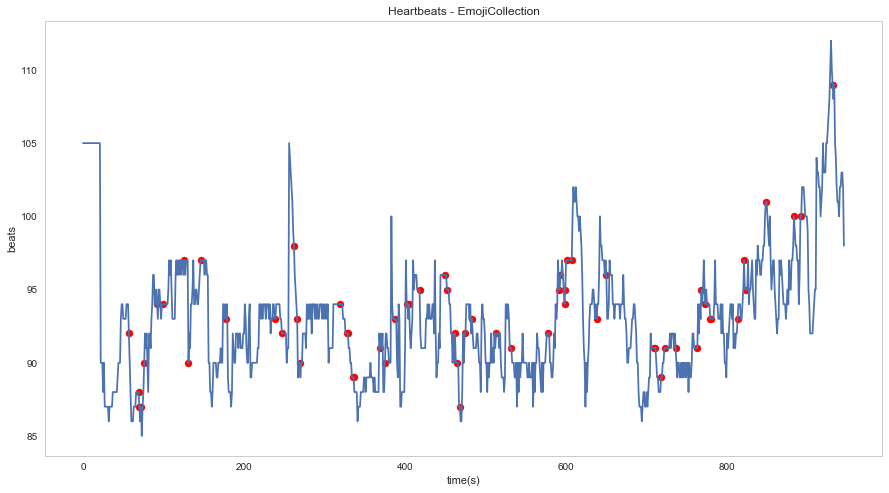

In [10]:
e_timestamp = []
for session in player1['EmojiTimestamps']:       
    e_timestamp += get_track_emoj(session)
    
xi = []
track = []   

for i,t in enumerate(times1):

    for e in e_timestamp:
        if abs((de_timestampe(e)-de_timestampe(t)).seconds) < 1:
            xi.append(i)        
            track.append(int(rates1[i]))        
                        
fig, ax = plt.subplots(figsize=(15,8))
markers_on = track
plt.plot(rates1)
plt.scatter(xi,track,c="r",s=50)
#plt.xticks(x,times1, rotation="60")
plt.title("Heartbeats - EmojiCollection")
ax.set_xlabel("time(s)")
ax.set_ylabel("beats")

plt.show()

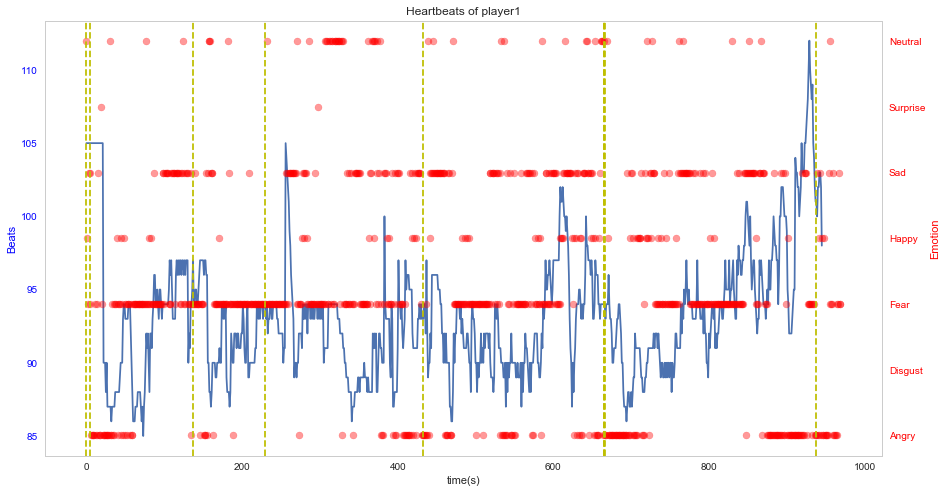

In [11]:
# plot
x1 = diffx1.seconds
fig, ax1 = plt.subplots(figsize=(15,8))
plt.title("Heartbeats of player1")

#plt.scatter(timestamps1, rates1)
ax2 = ax1.twinx()

ax1.plot(rates1)
ax1.tick_params('y', colors='b')

emotions = []
i=0
while(i<=len(result)):
    emotions.append(int(result[i]))
    i = i+len(result)//len(rates1)

ax2.scatter(range(0,len(emotions)),emotions,color="r",s=50,alpha=.4)
ax2.tick_params('y', colors='r')

#plt.ylim([70,150])
for f in flags:
    plt.axvline(x=f, color='y', linestyle='--')

#plt.text(x1,120, str(x1)+"  >>>", size=15, fontweight='bold')

ax1.set_xlabel("time(s)")
ax1.set_ylabel("Beats", color="b")

ax2.set_ylabel('Emotion', color="r")
ax2.set_yticklabels(["","Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral",""])

plt.show()

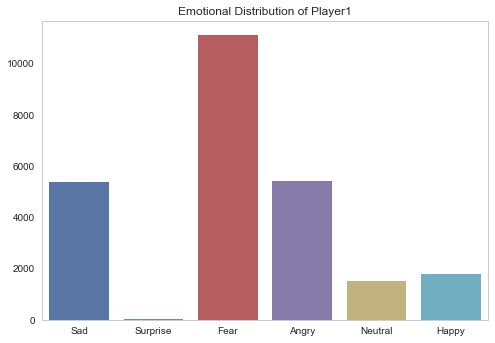

In [12]:
liter = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
final_result = [liter[i] for i in result]
es = []
fs = []
rs = Counter(final_result)
for v in rs:
    es.append(v)
    fs.append(rs[v])

sns.barplot(es, fs)
plt.title("Emotional Distribution of Player1")
plt.show()

#### Heart rates analysis from  player2

In [13]:
# playing span
s2 = player2['TimeStarted'].values[0]
e2 = player2['TimeEnded'].values[-1]
sx2 = player2['TimeStarted'].values[-1]
diff2 = (de_timestampe(e2) - de_timestampe(s2)) # difference in second
diffx2 = (de_timestampe(e2) - de_timestampe(sx2)) # difference in seconds

# get timestamp and HR
times2 = []
rates2 = []

for session in player2['Heartbeats']:       
    time, rate = extract_split_data(session)
    times2 += time 
    rates2 += rate
    
print ("Player2")
print ("Time: {} minutes, {} ~ {}".format(round(diff2.seconds/60,2), s2.split()[1], e2.split()[1]))
print ("Game Sessions: {}".format(player2.shape[0]))
print ("Scores: {}".format(player2["Score"].values))
print ("Emoj Scores: {}".format(player2["EmojiScore"].values))
print ("Variance of HR: {}".format(np.var(rates2)))
print ("Average of HR: {}".format(np.mean(rates2)))
print ("Mode of HR: {}".format(mode(rates2)))

Player2
Time: 4.52 minutes, 20:07:20.8200 ~ 20:11:52.3070
Game Sessions: 1
Scores: [89]
Emoj Scores: [16]
Variance of HR: 6.6809876543209885
Average of HR: 75.42222222222222
Mode of HR: 75


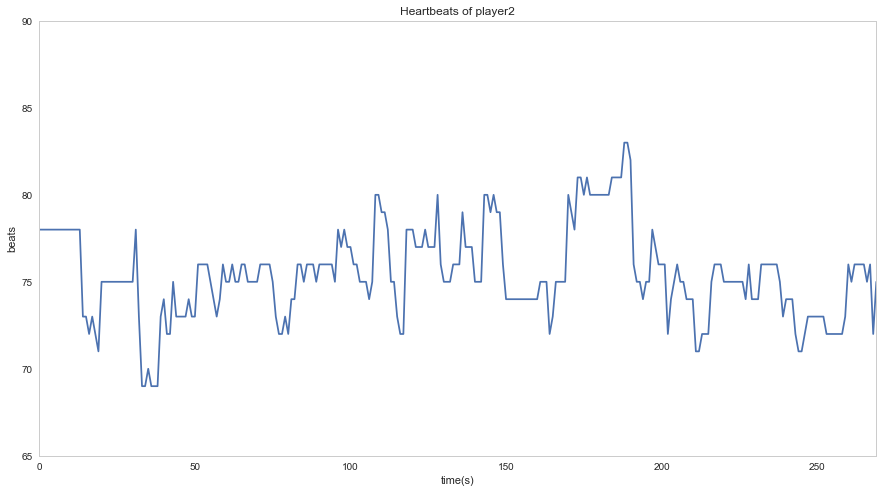

In [14]:
# plot
timestamps2 = pd.to_datetime(times2)
x2 = diffx2.seconds

fig, ax = plt.subplots(figsize=(15,8))
plt.title("Heartbeats of player2")
#plt.scatter(timestamps1, rates1)
sns.tsplot(rates2)
plt.ylim([65,90])
#plt.xticks(x, times, rotation="60")


ax.set_xlabel("time(s)")
ax.set_ylabel("beats")

plt.show()

#### Playing Pattern

In [15]:
m1 = player1["Movement"]
m2 = player2["Movement"]
print (m1[:5])
print (m2[:5])

0                                                   []
1                 [277.626, 328.269, 335.523, 389.984]
2    [323.592, 356.954, 432.456, 380.225, 447.929, ...
3    [313.294, 371.369, 394.887, 437.292, 475.276, ...
4    [307.845, 395.124, 462.828, 470.082, 402.47, 4...
Name: Movement, dtype: object
0    [330.334, 398.038, 387.24, 363.418, 391.958, 3...
Name: Movement, dtype: object


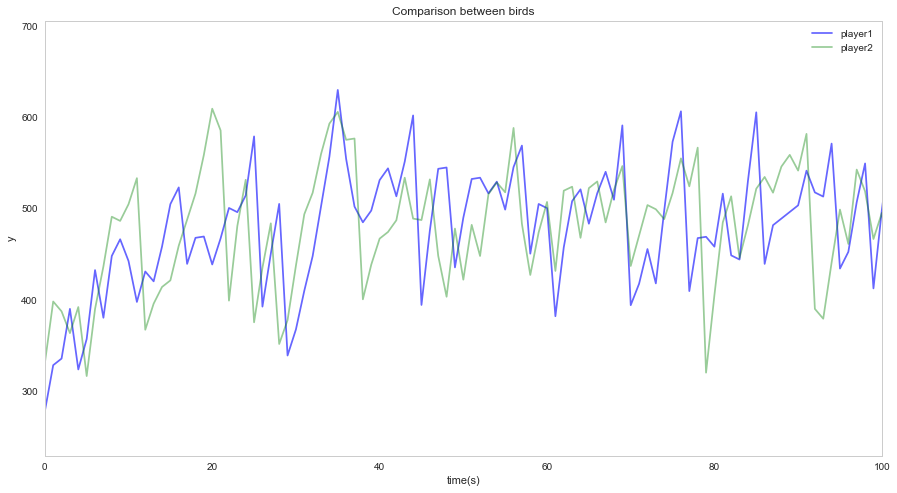

In [16]:
y1 = de_movement(m1)
y2 = de_movement(m2)

fig, ax = plt.subplots(figsize=(15,8))
plt.title("Comparison between birds")
#plt.scatter(timestamps1, rates1)
plt.plot(y1, color="b", label="player1", alpha=.6)
plt.plot(y2, color="g", label="player2", alpha=.4)
plt.xlim([0,100])
ax.set_xlabel("time(s)")
ax.set_ylabel("y")
plt.legend()
plt.show()

In [17]:
yy1 = (y1-np.mean(y1))/np.std(y1)
yy2 = (y2-np.mean(y2))/np.std(y2)

In [20]:
dist, cost, acc, path = dtw(yy1, yy2, dist=euclidean)
dist1, cost1, acc1, path1 = dtw(yy1[:300], yy2[:300], dist=euclidean)

In [21]:
print("Whole Game Sessions: {}".format(dist))
print("During Same Period: {}".format(dist1))

Whole Game Sessions: 0.4094384754427199
During Same Period: 0.25897511426283987


Populating the interactive namespace from numpy and matplotlib


(-0.5, 293.5)

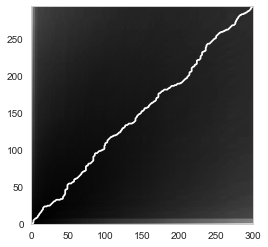

In [33]:
%pylab inline
imshow(acc1.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path1[0], path1[1], 'w')
xlim((-0.5, acc1.shape[0]-0.5))
ylim((-0.5, acc1.shape[1]-0.5))

In [37]:
# similarity for own movement
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [43]:
seq = yy1[:100]
sub = window(seq, 10)
print (sub)

<generator object window at 0x1177353b8>
